## Load Training Data

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

%matplotlib inline

# make plots look betters
plt.style.use('ggplot')
# plt.rcParams['figure.figsize'] = (8,6)
# plt.rcParams['figure.dpi'] = (300)
plt.rcParams['font.size'] = 12

comments = pd.read_pickle('../toxic_comment_data/combined_train_data.csv')

## Feature Extraction

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

# allows us to select a column by name from a data frame and return it as a nparray of type string
class TextExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def transform(self, data):
        return np.asarray(data[self.column]).astype(str)
    
    # not used
    def fit(self, *_):
        return self 

# allows us to select a column by name from a data frame and return it as a nparray of the specified type
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column, dtype):
        self.dtype = dtype
        self.column = column

    def transform(self, data):
        data = np.asarray(data[self.column]).astype(self.dtype)
         
        # note: reshaping is necessary because otherwise sklearn
        # interprets 1-d array as a single sample
        # reshapes from row vector to column vector
        data = data.reshape(data.size, 1) 
        return data
    
    # not used
    def fit(self, *_):
        return self

In [21]:
char_ngram_features = Pipeline([
    ('extractor', TextExtractor('Comment')),
    ('vectorizer', CountVectorizer(analyzer='char', ngram_range=(1, 3), stop_words=None)),
    ('tfidf', TfidfTransformer(use_idf=True))
])

word_ngram_features = Pipeline([
    ('extractor', TextExtractor('Comment')),
    ('vectorizer', CountVectorizer(analyzer='word', ngram_range=(1, 1), stop_words='english')),
    ('tfidf', TfidfTransformer(use_idf=True))
])

# the features combined
features = FeatureUnion([
    ('char_ngrams', char_ngram_features),
    ('word_ngrams', word_ngram_features),
    ('norm_length', ColumnExtractor('Norm_True_Length',float)),
    ('weekday', ColumnExtractor('Weekday',int)),
    ('day', ColumnExtractor('Day',int)),
    ('month', ColumnExtractor('Month',int)),
    ('year', ColumnExtractor('Year',int)),
    ('hour', ColumnExtractor('Hour',int)),
    ('minute', ColumnExtractor('Minute',int)),
    ('second', ColumnExtractor('Second',int))
])

# set the classifier
classifier = LogisticRegression()

# set the feature selection
select = SelectPercentile(score_func=chi2, percentile=50)

pipeline = Pipeline([
    ('union', features),
    ('select', select),
    ('classifier', classifier)
])

In [6]:
char_ngram_features = Pipeline([
    ('extractor', TextExtractor('Comment')),
    ('vectorizer', CountVectorizer(analyzer='char')),
    ('tfidf', TfidfTransformer())
])

word_ngram_features = Pipeline([
    ('extractor', TextExtractor('Comment')),
    ('vectorizer', CountVectorizer(analyzer='word')),
    ('tfidf', TfidfTransformer())
])

# the features combined
features = FeatureUnion([
    ('char_ngrams', char_ngram_features),
    ('word_ngrams', word_ngram_features),
    ('norm_length', ColumnExtractor('Norm_True_Length',float)),
    ('weekday', ColumnExtractor('Weekday',int)),
    ('day', ColumnExtractor('Day',int)),
    ('month', ColumnExtractor('Month',int)),
    ('year', ColumnExtractor('Year',int)),
    ('hour', ColumnExtractor('Hour',int)),
    ('minute', ColumnExtractor('Minute',int)),
    ('second', ColumnExtractor('Second',int))
])

# set the classifier
classifier = DummyClassifier(strategy='most_frequent')

# set the feature selection
select = SelectPercentile(score_func=chi2, percentile=25)

pipeline = Pipeline([
    ('union', features),
    ('select', select),
    ('classifier', classifier)
])

In [7]:
pipeline.fit(comments, comments.Insult);

In [28]:
char_ngram_features = Pipeline([
    ('extractor', TextExtractor('Comment')),
    ('vectorizer', CountVectorizer(analyzer='char')),
    ('tfidf', TfidfTransformer())
])

word_ngram_features = Pipeline([
    ('extractor', TextExtractor('Comment')),
    ('vectorizer', CountVectorizer(analyzer='word')),
    ('tfidf', TfidfTransformer())
])

# the features combined
features = FeatureUnion([
    ('char_ngrams', char_ngram_features),
    ('word_ngrams', word_ngram_features),
    ('norm_length', ColumnExtractor('Norm_True_Length',float)),
    ('weekday', ColumnExtractor('Weekday',int)),
    ('day', ColumnExtractor('Day',int)),
    ('month', ColumnExtractor('Month',int)),
    ('year', ColumnExtractor('Year',int)),
    ('hour', ColumnExtractor('Hour',int)),
    ('minute', ColumnExtractor('Minute',int)),
    ('second', ColumnExtractor('Second',int))
])

# set the classifier
classifier = LogisticRegression(class_weight=None, fit_intercept=True, tol=0.00001, max_iter=50)

# set the feature selection
select = SelectPercentile(score_func=chi2, percentile=25)

pipeline = Pipeline([
    ('union', features),
    ('select', select),
    ('classifier', classifier)
])

In [29]:
pipeline.fit(comments, comments.Insult);

## Grid Search Example

In [24]:
from timeit import default_timer as timer

start = timer() # start timer so we can see how long it takes

# IF YOU RUN THIS AS IS IT WILL TAKE AN HOUR OR TWO TO FINISH
parameters = {
                'classifier__fit_intercept' : [True, False],
                'classifier__tol' : [0.0001, 0.00001, 0.000001],
                'classifier__class_weight' : [None, 'balanced'],
                'classifier__max_iter' : [50, 100, 250, 500],
             }

gs_clf3 = GridSearchCV(pipeline, parameters, n_jobs=-1) # run the grid search on the chosen pipeline
gs_clf3 = gs_clf3.fit(comments, comments.Insult) 

end = timer()
print(end - start)

290.208329829009


In [16]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score
 
prediction = gs_clf3.predict(comments)
precise = precision_score(comments.Insult, prediction)
recall = recall_score(comments.Insult, prediction)
auc = roc_auc_score(comments.Insult, prediction)

print("Classifier Hyperparameters Grid search with constant features:")
print(gs_clf3.best_score_)
print(gs_clf3.best_params_)
print('precision: ', str(precise), ', recall: ', str(recall), ', auc: ', str(auc))

Classifier Hyperparameters Grid search with constant features:
0.835201793722
{'classifier__class_weight': None, 'classifier__fit_intercept': True, 'classifier__max_iter': 50, 'classifier__tol': 1e-05}
precision:  0.947942905122 , recall:  0.712302839117 , auc:  0.847922059325


In [26]:
print("Classifier Hyperparameters Grid search:")
print(gs_clf1.best_score_)
print(gs_clf1.best_params_)

Classifier Hyperparameters Grid search:
0.823430493274
{'classifier__class_weight': None, 'classifier__fit_intercept': True, 'classifier__penalty': 'l1', 'classifier__tol': 1e-05, 'select__percentile': 20}


In [30]:
start = timer()
parameters = {
                'union__char_ngrams__vectorizer__ngram_range': [(1, 1), (1, 2), (1,3)], # the range of the n-grams
                'union__char_ngrams__vectorizer__stop_words': [None, 'english'], # remove stopwords or not
                'union__char_ngrams__tfidf__use_idf': (True, False), # use idf or not
                'union__word_ngrams__vectorizer__ngram_range': [(1, 1), (1, 2), (1,3)],
                'union__word_ngrams__vectorizer__stop_words': [None, 'english'],
                'union__word_ngrams__tfidf__use_idf': (True, False),
                'select__percentile' : [5,10,20,50], # percentage of best features to select
             }

gs_clf2 = GridSearchCV(pipeline, parameters, n_jobs=-1) # run the grid search on the chosen pipeline
gs_clf2 = gs_clf2.fit(comments, comments.Insult) 
end = timer()
print("GridSearch took:")
print(end - start)

GridSearch took:
2677.952932546992


In [31]:
print("Training time:", round((end-start)/60/60,2), "hours")

Training time: 0.74 hours


Print out the best score found, and the parameters that go with it:

In [33]:
print(gs_clf2.best_score_)
print(gs_clf2.best_params_)

0.835201793722
{'select__percentile': 50, 'union__char_ngrams__tfidf__use_idf': True, 'union__char_ngrams__vectorizer__ngram_range': (1, 3), 'union__char_ngrams__vectorizer__stop_words': None, 'union__word_ngrams__tfidf__use_idf': True, 'union__word_ngrams__vectorizer__ngram_range': (1, 1), 'union__word_ngrams__vectorizer__stop_words': 'english'}


In [34]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score
 
prediction = gs_clf2.predict(comments)
precise = precision_score(comments.Insult, prediction)
recall = recall_score(comments.Insult, prediction)
auc = roc_auc_score(comments.Insult, prediction)

print("Classifier Hyperparameters Grid search with constant features:")
print(gs_clf2.best_score_)
print(gs_clf2.best_params_)
print('precision: ', str(precise), ', recall: ', str(recall), ', auc: ', str(auc))

Classifier Hyperparameters Grid search with constant features:
0.835201793722
{'select__percentile': 50, 'union__char_ngrams__tfidf__use_idf': True, 'union__char_ngrams__vectorizer__ngram_range': (1, 3), 'union__char_ngrams__vectorizer__stop_words': None, 'union__word_ngrams__tfidf__use_idf': True, 'union__word_ngrams__vectorizer__ngram_range': (1, 1), 'union__word_ngrams__vectorizer__stop_words': 'english'}
precision:  0.947942905122 , recall:  0.712302839117 , auc:  0.847922059325


In [9]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score
 
prediction = pipeline.predict(comments)
precise = precision_score(comments.Insult, prediction)
recall = recall_score(comments.Insult, prediction)
auc = roc_auc_score(comments.Insult, prediction)

print("Classifier Hyperparameters Grid search with constant features:")
print('precision: ', str(precise), ', recall: ', str(recall), ', auc: ', str(auc))

Classifier Hyperparameters Grid search with constant features:
precision:  0.0 , recall:  0.0 , auc:  0.5


/Users/rrvdw/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


See how the new classifier does on accuracy: (noticeable improvement)

In [28]:
test = pd.read_pickle("../toxic_comment_data/labeled_test_set_with_features.csv")
predicted = pipeline.predict(test)
predicted1 = gs_clf1.predict(test)
predicted2 = gs_clf2.predict(test)
print("Base Accuracy:")
print(np.mean(predicted == test.Insult))
print("Accuracy after GridSearch 1:")
print(np.mean(predicted1 == test.Insult))
print("Accuracy after GridSearch 2:")
print(np.mean(predicted2 == test.Insult))

Base Accuracy:
0.681879194631
Accuracy after GridSearch 1:
0.685458612975
Accuracy after GridSearch 2:
0.701118568233


In [13]:
plot_roc(test.Insult, predicted)

NameError: name 'plot_roc' is not defined

In [21]:
def plot_roc(test_labels, predicted_labels):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels,predicted_labels)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    plt.title('ROC for Logistic Regression')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate');

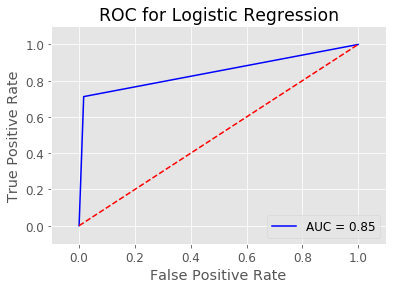

In [22]:
predicted_logres = gs_clf2.predict(comments)
plot_roc(comments.Insult, predicted_logres)

In [18]:
from sklearn.externals import joblib
#joblib.dump(gs_clf1, 'gs_clf1.pkl');
#joblib.dump(gs_clf2, 'gs_clf2.pkl');
#joblib.dump(gs_clf2, 'gs_clf2_new.pkl');
gs_clf2 = joblib.load('gs_clf2_new.pkl')
